# Import Library

In [171]:
import pandas as pd

from sklearn.model_selection import train_test_split

#  untuk text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Untuk Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, regularizers,initializers
from tensorflow.keras.layers import Embedding
from keras.models import Sequential

from matplotlib import pyplot as plt


# Membaca Dataset

In [172]:
df = pd.read_csv('df_final.csv')

In [173]:
del df['Unnamed: 0']

# Split Data

In [174]:

X = df['content'].values
y = df['label'].values
#buat data test dan traning
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = True, random_state = 1)

#buat data validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 1) 


## Melihat hasil split data

In [175]:
print(f'Bentuk X_train = {X_train.shape}',
      f'Bentuk Y_train = {y_train.shape}',
      f'Bentuk X_val = {X_val.shape}',
      f'Bentuk Y_val = {y_val.shape}',
      f'Bentuk X_test = {X_test.shape}',
      f'Bentuk Y_test = {y_test.shape}', sep="\n")

Bentuk X_train = (593,)
Bentuk Y_train = (593,)
Bentuk X_val = (198,)
Bentuk Y_val = (198,)
Bentuk X_test = (198,)
Bentuk Y_test = (198,)


# Tokenizer

In [176]:
NUM_WORDS = 15000

tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.fit_on_texts(X_train)

# Sequence

In [178]:
x_train_token = tokenizer.texts_to_sequences(X_train)
x_test_token = tokenizer.texts_to_sequences(X_test)
x_val_token =tokenizer.texts_to_sequences(X_val)

# Padding

In [179]:
MAXLEN = 250

x_train_padding = pad_sequences(x_train_token, maxlen=MAXLEN, padding='post', truncating='post')
x_test_padding = pad_sequences(x_test_token, maxlen=MAXLEN, padding='post', truncating='post')
x_valdding_padding = pad_sequences(x_val_token, maxlen=MAXLEN, padding='post', truncating='post')
embeding_dim = 16

# Modeling

In [180]:

model = tf.keras.Sequential([
    Embedding(input_dim=NUM_WORDS, input_length=MAXLEN, output_dim=20),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 20)           300000    
                                                                 
 global_max_pooling1d_5 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 6)                 126       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 300,133
Trainable params: 300,133
Non-trainable params: 0
_________________________________________________________________


## Early Stopping

In [181]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## Callbacks

In [182]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>= 0.96):
      print("\nAkurasi validasi telah mencapai >95%!")
      self.model.stop_training = True
callbacks = MyCallback()

## Model Compile

In [183]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Model Fitting


In [184]:
EPOCHS = 30
BATCH_SIZE = 30
history = model.fit(x_train_padding,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_valdding_padding, y_val),
                    verbose=1,
                    callbacks = early_stopping)

Epoch 1/30
20/20 [==============================] - 1s 12ms/step - loss: 0.6806 - accuracy: 0.6492 - val_loss: 0.6705 - val_accuracy: 0.6919
Epoch 2/30
20/20 [==============================] - 0s 5ms/step - loss: 0.6677 - accuracy: 0.6492 - val_loss: 0.6557 - val_accuracy: 0.6919
Epoch 3/30
20/20 [==============================] - 0s 6ms/step - loss: 0.6548 - accuracy: 0.6492 - val_loss: 0.6406 - val_accuracy: 0.6919
Epoch 4/30
20/20 [==============================] - 0s 6ms/step - loss: 0.6411 - accuracy: 0.6492 - val_loss: 0.6256 - val_accuracy: 0.6919
Epoch 5/30
20/20 [==============================] - 0s 6ms/step - loss: 0.6267 - accuracy: 0.6492 - val_loss: 0.6106 - val_accuracy: 0.6919
Epoch 6/30
20/20 [==============================] - 0s 5ms/step - loss: 0.6094 - accuracy: 0.6492 - val_loss: 0.5881 - val_accuracy: 0.6919
Epoch 7/30
20/20 [==============================] - 0s 5ms/step - loss: 0.5830 - accuracy: 0.6492 - val_loss: 0.5653 - val_accuracy: 0.6919
Epoch 8/30
20/20 [=

## Evaluasi Model

In [185]:
score = model.evaluate(x_test_padding,y_test, verbose = 0)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

ACCURACY: 0.8636363744735718
LOSS: 0.34855446219444275


## Visualisasi hasil model


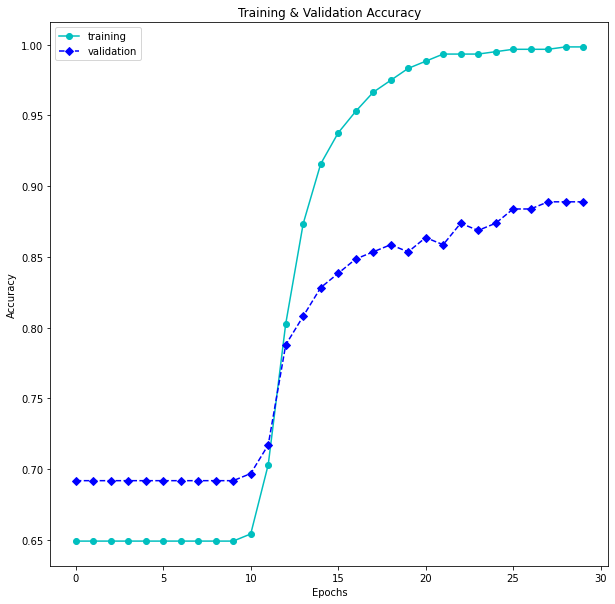

In [186]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['accuracy'])), 
         history.history['accuracy'],
         'co-',
         label='training')
plt.plot(range(len(history.history['val_accuracy'])), 
         history.history['val_accuracy'],
         'bD--',
         label='validation')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


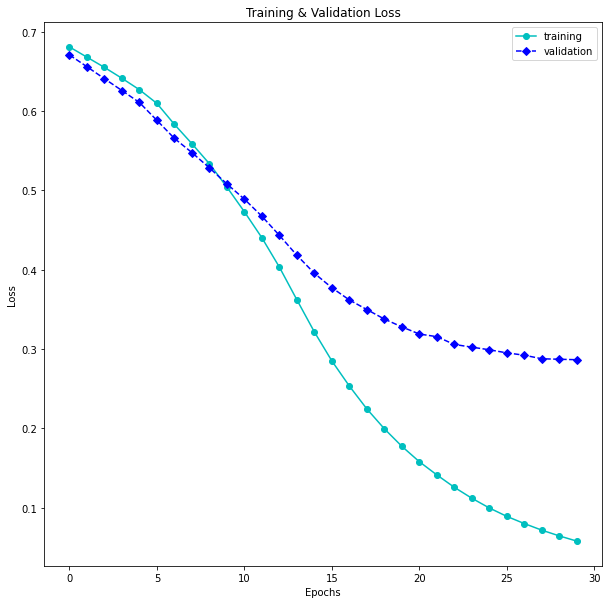

In [200]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['loss'])), 
         history.history['loss'],
          'co-',
         label='training')
plt.plot(range(len(history.history['val_loss'])), 
         history.history['val_loss'],
         'bD--',
         label='validation')
plt.title('Training & Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


## Menyimpan Model

In [188]:
model.save('model1.h5')

In [189]:
load = tf.keras.models.load_model('model1.h5')

## Testing Model

In [190]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
SENTIMENT_THRESHOLDS = (0.4, 0.7)
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEGATIVE
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [191]:
def Predict(text, include_neutral=True):
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAXLEN)
    # Predict
    score = load.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=False)

    return {"label": label, "score": float(score)} 

In [193]:
Predict("aplikasi ini jelek, tolong diperbaiki lagi karna banyak error ")

1/1 [==============================] - 0s 24ms/step


{'label': 'NEGATIVE', 'score': 0.049197059124708176}

In [197]:
Predict("aplikasinya sangat bagus, saya sangat tertolong karena bebas biaya admin")

1/1 [==============================] - 0s 24ms/step


{'label': 'POSITIVE', 'score': 0.8528755307197571}